In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Cell 1: Define your CustomDataset class with multi-class support

import os
import json
import torch
import torchvision
import torch.utils.data
import numpy as np
from PIL import Image
from torchvision.models.detection.mask_rcnn import MaskRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.mask_rcnn import maskrcnn_resnet50_fpn
from skimage.draw import polygon
import pycocotools.mask as mask_util

# Helper function to decode RLE to a binary mask
def decode_rle_to_mask(rle_data):
    rle_dict = {
        'counts': rle_data['counts'],
        'size': rle_data['size']
    }
    return mask_util.decode(rle_dict)

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images_flood"))))

        # Mapping from original COCO-style category IDs to model's sequential labels
        self.class_mapping = {
            1: 1,  # person
            2: 2,  # bicycle
            3: 3,  # car
            6: 4,  # bus
            91: 5, # flood
            92: 6  # house
        }

        json_path = os.path.join(root, "flood_dict_new.json")
        with open(json_path, 'r') as f:
            self.annotations = json.load(f)

    def __getitem__(self, idx):
        img_name = os.path.splitext(self.imgs[idx])[0]
        img_path = os.path.join(self.root, "images_flood", self.imgs[idx])
        img = Image.open(img_path).convert("RGB")

        ann_list = self.annotations.get(img_name, [])

        boxes = []
        labels = []
        masks = []

        for ann in ann_list:
            category_id = ann.get('category_id')

            # Check if the category is one of the classes we are interested in
            if category_id in self.class_mapping:
                x1, y1, w, h = ann['bbox']
                x2 = x1 + w
                y2 = y1 + h
                boxes.append([x1, y1, x2, y2])

                # Append the mapped label
                labels.append(self.class_mapping[category_id])

                segmentation = ann['segmentation']
                mask = decode_rle_to_mask(segmentation)
                masks.append(mask)

        # Convert to tensors
        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
            masks = torch.zeros((0, img.height, img.width), dtype=torch.uint8)
        else:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
            masks = torch.as_tensor(np.stack(masks), dtype=torch.uint8)

        image_id = torch.tensor([idx])
        target = {"boxes": boxes, "labels": labels, "masks": masks, "image_id": image_id}

        if self.transforms is not None:
            # Note: The custom_transform in the original code does not correctly transform targets.
            # A proper implementation would handle bounding box and mask adjustments.
            # For simplicity, we assume the ToTensor() transform is the primary one for the image.
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

print("CustomDataset class defined with multi-class support and annotation parsing.")

CustomDataset class defined with multi-class support and annotation parsing.


In [ ]:
# Cell 3: Define transforms and create datasets
def get_transform(train):
    transforms = []
    # Convert image to tensor
    transforms.append(torchvision.transforms.ToTensor())
    # Add horizontal flip for data augmentation
    if train:
        transforms.append(torchvision.transforms.RandomHorizontalFlip(0.5))

    # A custom function to apply the transforms to both image and target
    def custom_transform(image, target):
        for transform in transforms:
            image = transform(image)
        return image, target

    return custom_transform

# Path to the root directory of your dataset
dataset_root = "data"

# create training and validation datasets
dataset = CustomDataset(dataset_root, get_transform(train=True))
dataset_test = CustomDataset(dataset_root, get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=2,
    collate_fn=lambda x: tuple(zip(*x))
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=2,
    collate_fn=lambda x: tuple(zip(*x))
)

print("Datasets and DataLoaders created.")

Datasets and DataLoaders created.


In [ ]:
# Cell 4: Load a pre-trained model and modify it for multiple classes

weights = torchvision.models.detection.MaskRCNN_ResNet50_FPN_Weights.DEFAULT
model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights=weights, trainable_backbone_layers=3)

# Update the number of classes: 6 classes + 1 background
num_classes = 7

# Get the number of input features for the box classifier and replace the head
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Get the number of input features for the mask classifier and replace the head
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

print(f"Model loaded and modified for {num_classes} classes.")

Model loaded and modified for 7 classes.


In [ ]:
# Cell 5: Set up optimizer and move model to device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

print("Optimizer and device set up.")

# Cell 6: Implement the training loop
from tqdm import tqdm
num_epochs = 10

for epoch in range(num_epochs):
    print(f"Starting epoch {epoch+1}/{num_epochs}")
    model.train()

    # Use tqdm to show a progress bar for the DataLoader
    for images, targets in tqdm(data_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    # update the learning rate
    lr_scheduler.step()
    print(f"Epoch {epoch+1} finished. Total Loss: {losses.item()}")

print("Training finished.")

# Cell 7: Save the trained model
torch.save(model.state_dict(), "mask_rcnn_flood.pth")


Optimizer and device set up.
Starting epoch 1/10


100%|██████████| 609/609 [01:45<00:00,  5.79it/s]


Epoch 1 finished. Total Loss: 1.2990314960479736
Starting epoch 2/10


100%|██████████| 609/609 [01:44<00:00,  5.85it/s]


Epoch 2 finished. Total Loss: 3.838477373123169
Starting epoch 3/10


100%|██████████| 609/609 [01:44<00:00,  5.84it/s]


Epoch 3 finished. Total Loss: 1.0172131061553955
Starting epoch 4/10


100%|██████████| 609/609 [01:43<00:00,  5.88it/s]


Epoch 4 finished. Total Loss: 0.7633612155914307
Starting epoch 5/10


100%|██████████| 609/609 [01:43<00:00,  5.87it/s]


Epoch 5 finished. Total Loss: 1.4512505531311035
Starting epoch 6/10


100%|██████████| 609/609 [01:42<00:00,  5.94it/s]


Epoch 6 finished. Total Loss: 0.25258275866508484
Starting epoch 7/10


100%|██████████| 609/609 [01:42<00:00,  5.93it/s]


Epoch 7 finished. Total Loss: 0.42604780197143555
Starting epoch 8/10


100%|██████████| 609/609 [01:43<00:00,  5.86it/s]


Epoch 8 finished. Total Loss: 1.2400726079940796
Starting epoch 9/10


100%|██████████| 609/609 [01:43<00:00,  5.89it/s]


Epoch 9 finished. Total Loss: 0.7453555464744568
Starting epoch 10/10


100%|██████████| 609/609 [01:42<00:00,  5.95it/s]


Epoch 10 finished. Total Loss: 2.152419328689575
Training finished.


In [4]:
# Cell 8: Load the trained model and set it to evaluation mode
import torch
import torchvision
from torchvision.models.detection.mask_rcnn import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights

weights = torchvision.models.detection.MaskRCNN_ResNet50_FPN_Weights.DEFAULT
model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights=weights, trainable_backbone_layers=3)

# Update the number of classes: 6 classes + 1 background
num_classes = 7

# Get the number of input features for the box classifier and replace the head
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Get the number of input features for the mask classifier and replace the head
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

# Load the saved state dictionary
model_path = "/content/drive/MyDrive/mask_rcnn_flood.pth"
model.load_state_dict(torch.load(model_path))

# Move the model to the correct device and set it to evaluation mode
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
model.eval()

print("Trained model loaded successfully.")

Trained model loaded successfully.


In [6]:
# Cell 9: Make a prediction on a new image
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np

# Path to a new image you want to test
# You can upload a new image to your Colab session or use one from your dataset
test_image_path = "/content/drive/MyDrive/Flood_image.jpg"

# Preprocess the image
img = Image.open(test_image_path).convert("RGB")
transform = T.Compose([T.ToTensor()])
img_tensor = transform(img).unsqueeze(0).to(device)

# Get predictions
with torch.no_grad():
    prediction = model(img_tensor)

# The prediction contains boxes, labels, scores, and masks
boxes = prediction[0]['boxes'].cpu().numpy()
masks = prediction[0]['masks'].cpu().numpy()
scores = prediction[0]['scores'].cpu().numpy()
labels = prediction[0]['labels'].cpu().numpy()

# You can now filter the predictions based on a confidence threshold
threshold = 0.7  # You can adjust this value
filtered_indices = np.where(scores > threshold)[0]
filtered_boxes = boxes[filtered_indices]
filtered_masks = masks[filtered_indices]
filtered_labels = labels[filtered_indices]

/tmp/ipython-input-1389805146.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(CLASS_NAMES)).colors


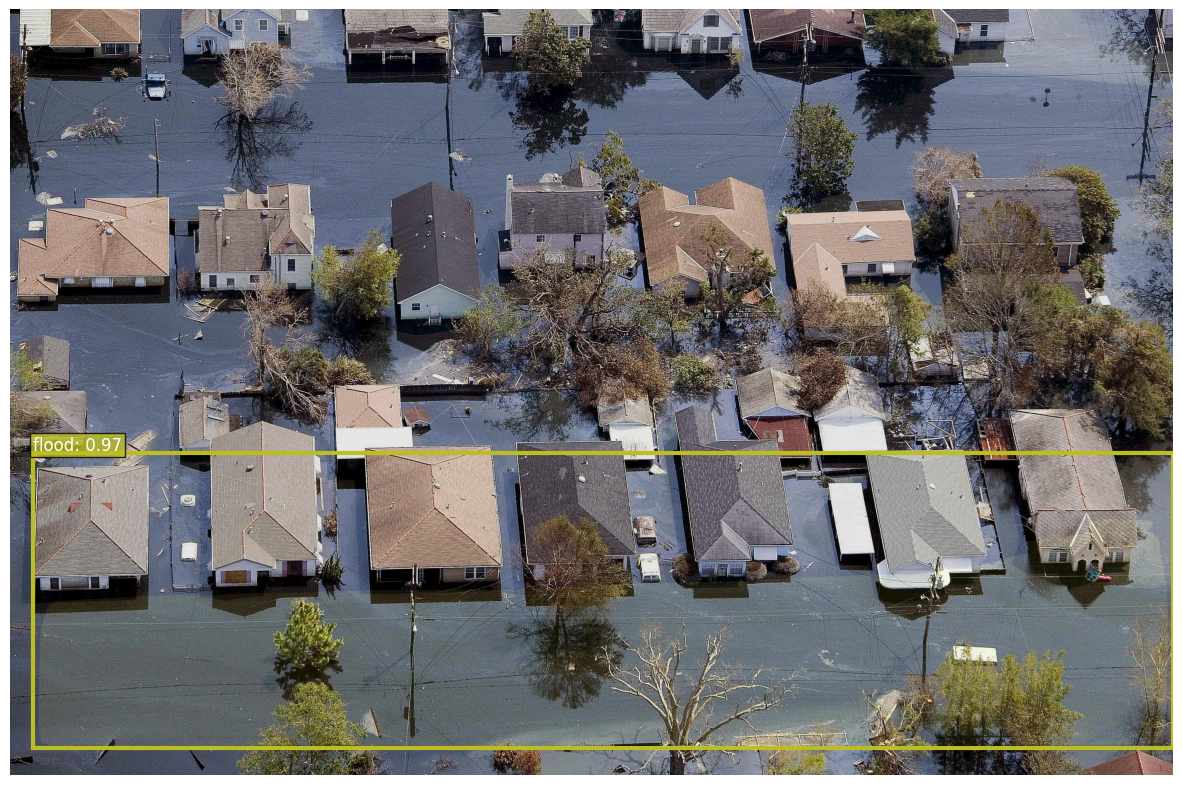

In [7]:
# Cell 10: Visualize results with unique colors and labels for each class
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Define the class names corresponding to your model's output indices
# Index 0 is background, 1 is person, ..., 6 is house
CLASS_NAMES = [
    'background', 'person', 'bicycle', 'car', 'bus', 'flood', 'house'
]

# Generate a list of distinct RGBA colors for each class
colors = plt.cm.get_cmap('tab10', len(CLASS_NAMES)).colors

plt.figure(figsize=(15, 15))
plt.imshow(img)
plt.axis('off')

# Iterate through the filtered predictions
for i in range(len(filtered_boxes)):
    box = filtered_boxes[i]
    label_idx = filtered_labels[i]
    score = scores[filtered_indices[i]]
    mask = filtered_masks[i].squeeze()

    # Get the color and name for the current class
    # THE FIX IS HERE: Slice the color tuple to get only the first 3 (RGB) values
    color = colors[label_idx % len(colors)][:3]
    class_name = CLASS_NAMES[label_idx]

    # 1. Draw the bounding box
    rect = plt.Rectangle(
        (box[0], box[1]), box[2] - box[0], box[3] - box[1],
        fill=False, edgecolor=color, linewidth=3
    )
    plt.gca().add_patch(rect)

    # 2. Display the label and confidence score
    label_text = f"{class_name}: {score:.2f}"
    plt.text(
        box[0], box[1] - 10, label_text,
        color='white', fontsize=12,
        bbox=dict(facecolor=color, alpha=0.8, pad=2)
    )

    # 3. Overlay the segmentation mask
    # Create a colored mask
    colored_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.float32)
    colored_mask[mask > 0.5] = color  # This line will now work correctly

    # Blend the mask with the image
    plt.imshow(colored_mask, alpha=0.1)

plt.show()